In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import pickle
import os
import matplotlib.pyplot as plt
from striatum.bandit import linucb
from utils.miscellaneous import *
plt.style.use('seaborn')

In [ ]:
def parse_data_from_file(data_file_paths, share_coeff=False):
    for data_file_path in data_file_paths:
        with gzip.open(data_file_path, 'rt') as file:
            for line in file:
                chunks = line.split('|')
                feature = {}
                timestamp, logged_arm_id, payoff = None, None, None
                for i, chunk in enumerate(chunks):
                    values = chunk.rstrip().split(' ')
                    if i == 0:
                        timestamp, logged_arm_id, payoff = values[0], int(values[1]), int(values[2])
                    elif len(values) == 7:
                        feature[values[0]] = np.array(list(map(lambda x: float(x.split(':')[1]), sorted(values[1:]))))
                arm_ids = set(feature.keys())
                arm_ids = set(map(lambda x: int(x), arm_ids.difference({'user'})))
                if not share_coeff:
                    context = {arm_id: feature['user'] for arm_id in arm_ids}
                else:
                    context = {arm_id: np.append(feature['user'], np.outer(
                        feature['user'], feature[str(arm_id)]).flatten()[1:]) for arm_id in arm_ids}
                yield arm_ids, context, logged_arm_id, payoff

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('logs/linucb_param_tuning.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [4]:
DATA_DIR_PATH = '/Users/a406127/Data/yahoo!_front_page_today_module_user_click_log/R6'
DATA_FILE_NAMES = ['ydata-fp-td-clicks-v1_0.20090501.gz']

In [5]:
data_file_paths = []
for data_file_name in DATA_FILE_NAMES:
    data_file_paths.append(os.path.join(DATA_DIR_PATH, data_file_name))

In [6]:
policy_learner = PolicyLearner(linucb.LinUCB, context_dimension=6, seed=0, reset_freq=1000000)
param_grid = {'alpha': np.linspace(0.0, 1.4, 8)}

In [7]:
results = search_param(logger, policy_learner, param_grid, parse_data_from_file, data_file_paths)

In [ ]:
with open('models/linucb_param_tuning.pkl', 'wb') as file:
    pickle.dump(results, file)

In [8]:
with open('models/linucb_param_tuning.pkl', 'rb') as file:
    results = pickle.load(file)

Best Parameter: {'alpha': 0.19999999999999998}
Cumulative CTR: 6.9332%


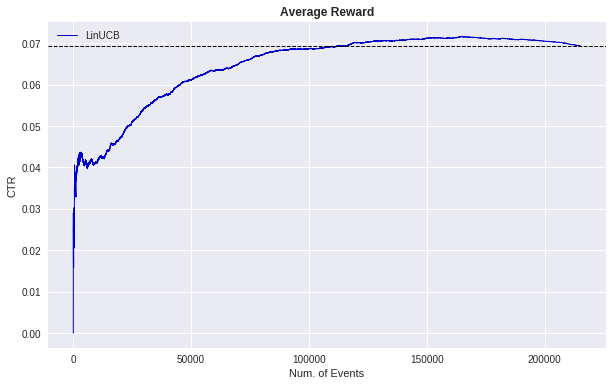

In [9]:
best_param = results['param'][np.argmax(results['avg_payoff'])]
cum_ctr = np.max(results['avg_payoff'])
print('Best Parameter: {0}\nCumulative CTR: {1:0.4%}'.format(best_param, cum_ctr))
fig, ax = plt.subplots(figsize=(10, 6))
_ = ax.plot(results['avg_payoff_seq'][np.argmax(results['avg_payoff'])], color='mediumblue', label='LinUCB', 
            linewidth=1)
ax.axhline(y=cum_ctr, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Num. of Events')
ax.set_ylabel('CTR')
ax.legend(loc='best')
_ = ax.set_title('Average Reward', fontsize=12, fontweight='bold')